# IMDb Ratings
## CMSC320 Spring 2017: Final Tutorial
## Wenhao Wang & Jeremy Choi

# Introduction
This tutorial will introduce you to some basic methods for scraping, parsing, and managing data from IMDb top 250 movies list, as well as performing exploratory data analysis, hypothesis testing, and machine learning on that data. The question we would like to answer in this tutorial is whether certain factors ascertained from the site correlate significantly with a film's rating.

## Overview and Content
In this tutorial, we will demonstrate: 
1. procurement of film data from the [IMDb top 250 movies list](http://www.imdb.com/chart/top?ref_=nv_mv_250_6) via python3's BeautifulSoup and requests libraries,
2. plotting of several variables and visualization of relationships between variables using pandas, matplotlib, and seaborn,
3. implementation of machine learning in the form of ordinary least squares,
4. and hypothesis testing using linear regression.

The following steps can be found in this tutorial:
1. [Data Curation and Parsing](#data-curation-and-parsing)
1. [Data Management](#data-management)
1. [Exploratory Data Analysis](#exploratory-data-analysis)
1. [Hypothesis Testing and Machine Learning](#hypothesis-testing-and-machine-learning)

## Installation of libraries
The steps in this tutorial require a couple of third party libraries which can be installed with `pip`:

    $ pip install seaborn

<a id="data-curation-and-parsing"></a>
# Data Curation and Parsing
Description of the scraping script.

In [1]:
import re
import string
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup

In [2]:
#Get the URL
r = requests.get('http://www.imdb.com/chart/top?ref_=nv_mv_250_6')
#Get text from the URL
html = r.text
#Use BeautifulSoup to read and parse the data to lxml
soup = BeautifulSoup(html, 'lxml')

movies = soup.select('td.titleColumn')
links = [a.attrs.get('href') for a in soup.select('td.titleColumn a')]
directorAndActors = [a.attrs.get('title') for a in soup.select('td.titleColumn a')]
ratings = [b.attrs.get('data-value') for b in soup.select('td.posterColumn span[name=ir]')]
ids = [b.attrs.get('data-tconst') for b in soup.select('td.watchlistColumn div[class=wlb_ribbon]')]

resultList = []
linkList = []
idList = []
for i in range(0, len(movies)):
    tempList = []
    movie_string = movies[i].get_text()
    movie = (' '.join(movie_string.split()).replace('.', ''))
    movie_title = movie[len(str(i))+1:-7]
    year = re.search('\((.*?)\)', movie_string).group(1)
    
    if (i < 10):
        rank = movie[0]
    elif (i < 100):
        rank = movie[0]+movie[1]
    else:
        rank = movie[0]+movie[1]+movie[2]
        
    director = directorAndActors[i].split(",")
    director = director[0].split(" (")
    
    tempList.append(int(rank))
    tempList.append(movie_title)
    tempList.append(int(year))
    tempList.append(director[0])
    tempList.append(float(ratings[i]))
    
    idList.append(ids[i])
    
    tempR = requests.get("http://www.imdb.com"+links[i])
    tempHtml = tempR.text 
    tempSoup = BeautifulSoup(tempHtml, 'lxml')

    rateVotes = tempSoup.select('span[class=small]')
    tempList.append(int(rateVotes[0].get_text().replace(',', '')))
    
    budget = tempSoup.select('div.txt-block')
    for n in range(0, len(budget)):
        if (str(budget[n].getText().split("h4")).find("udget") > -1 and
           str(budget[n].getText().split("h4")).find("$") > -1):
            tempList.append(int(str(budget[n].getText().split("h4")).split("$")[1].split(" ")[0].replace(',', '')))
            break
            
        if (n == len(budget)-1):
            tempList.append(0)
            break
    
    gross = tempSoup.select('div.txt-block')
    for o in range(0, len(gross)):
        if (str(gross[o].getText().split("h4")).find("ross") > -1 and
           str(gross[o].getText().split("h4")).find("$") > -1):
            tempList.append(int(str(gross[o].getText().split("h4")).split("$")[1].split(" ")[0].replace(',', '')))
            break
            
        if (o == len(gross)-2):
            tempList.append(0)
            break

    genres = tempSoup.select('span[itemprop=genre]')
    genres = [tag.get_text() for tag in genres]
    tempList.append(', '.join(genres))

    writers = tempSoup.select('div.credit_summary_item span[itemprop=creator]')
    tempstr = []
    for q in range(0, len(writers)):
        tempstr.append(writers[q].get_text().split("\n")[1].split(" (")[0])
    tempList.append(', '.join(tempstr))
    
    stars = tempSoup.select('div.credit_summary_item span[itemprop=actors]')
    tempstr = ""
    for k in range(0, len(stars)):
        tempstr = tempstr + stars[k].get_text().split("\n")[1].strip()+" "
    tempList.append(tempstr)
    
    country = tempSoup.select('div.txt-block a[itemprop=url]')
    tempstr = []
    for l in range(0, len(country)):
        if (str(country[l]).find("/title?country_of_origin") > -1):
            tempstr.append(country[l].getText())
    tempList.append(', '.join(tempstr))
    
    color = tempSoup.select('div.txt-block a[itemprop=url]')
    for m in range(0, len(color)):
        if (str(color[m]).find("/title?colors") > -1):
            tempList.append(color[m].getText())
            break
    
    production = tempSoup.select('div.txt-block span[itemprop=name]')
    tempstr = []
    for p in range(0, len(production)):
        tempstr.append(production[p].getText())
    tempList.append(', '.join(tempstr))
    
    linkList.append("http://www.imdb.com/"+links[i])
    resultList.append(tempList)

data_columns = ["rank","title","year","director","rating", "votes","budget","gross","genres",
                "writers","actors","country","color","production_co"]

# Create a dataframe with Pandas
df = pd.DataFrame(resultList, columns=data_columns)

In [3]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 14 columns):
rank             250 non-null int64
title            250 non-null object
year             250 non-null int64
director         250 non-null object
rating           250 non-null float64
votes            250 non-null int64
budget           250 non-null int64
gross            250 non-null int64
genres           250 non-null object
writers          250 non-null object
actors           250 non-null object
country          250 non-null object
color            250 non-null object
production_co    249 non-null object
dtypes: float64(1), int64(5), object(8)
memory usage: 27.4+ KB


,rank,title,year,director,rating,votes,budget,gross,genres,writers,actors,country,color,production_co
0,1,The Shawshank Redemption,1994,Frank Darabont,9.215845,1809548,25000000,28341469,"Crime, Drama","Stephen King, Frank Darabont","Tim Robbins, Morgan Freeman, Bob Gunton",USA,Color,Castle Rock Entertainment
1,2,The Godfather,1972,Francis Ford Coppola,9.161355,1235768,6000000,134821952,"Crime, Drama","Mario Puzo, Francis Ford Coppola","Marlon Brando, Al Pacino, James Caan",USA,Color,"Paramount Pictures, Alfran Productions"
2,3,The Godfather: Part II,1974,Francis Ford Coppola,8.998527,850412,13000000,57300000,"Crime, Drama","Francis Ford Coppola, Mario Puzo","Al Pacino, Robert De Niro, Robert Duvall",USA,Color,"Paramount Pictures, The Coppola Company"
3,4,The Dark Knight,2008,Christopher Nolan,8.948700,1789838,185000000,533316061,"Action, Crime, Drama","Jonathan Nolan, Christopher Nolan","Christian Bale, Heath Ledger, Aaron Eckhart","USA, UK",Color,"Warner Bros., Legendary Entertainment, Syncopy"
4,5,12 Angry Men,1957,Sidney Lumet,8.899511,490144,350000,0,"Crime, Drama","Reginald Rose, Reginald Rose","Henry Fonda, Lee J. Cobb, Martin Balsam",USA,Black and White,Orion-Nova Productions


<a id="data-management"></a>
# Data Management
This section involves handling missing data. We elected to simply drop rows where votes, budget, or gross are missing, to ensure we are using a consistent set of data for our visualizations. We would also like to clean up the categorical values so that they aren't followed by a superfluous delimiter ", ". This will make for easier string splitting later on.

In [4]:
tidy_df = df.loc[(df['votes'] > 0) & (df['budget'] > 0) & (df['gross'] > 0)]
tidy_df = tidy_df.reset_index(drop=True)
tidy_df.info()
tidy_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 14 columns):
rank             161 non-null int64
title            161 non-null object
year             161 non-null int64
director         161 non-null object
rating           161 non-null float64
votes            161 non-null int64
budget           161 non-null int64
gross            161 non-null int64
genres           161 non-null object
writers          161 non-null object
actors           161 non-null object
country          161 non-null object
color            161 non-null object
production_co    161 non-null object
dtypes: float64(1), int64(5), object(8)
memory usage: 17.7+ KB


,rank,title,year,director,rating,votes,budget,gross,genres,writers,actors,country,color,production_co
0,1,The Shawshank Redemption,1994,Frank Darabont,9.215845,1809548,25000000,28341469,"Crime, Drama","Stephen King, Frank Darabont","Tim Robbins, Morgan Freeman, Bob Gunton",USA,Color,Castle Rock Entertainment
1,2,The Godfather,1972,Francis Ford Coppola,9.161355,1235768,6000000,134821952,"Crime, Drama","Mario Puzo, Francis Ford Coppola","Marlon Brando, Al Pacino, James Caan",USA,Color,"Paramount Pictures, Alfran Productions"
2,3,The Godfather: Part II,1974,Francis Ford Coppola,8.998527,850412,13000000,57300000,"Crime, Drama","Francis Ford Coppola, Mario Puzo","Al Pacino, Robert De Niro, Robert Duvall",USA,Color,"Paramount Pictures, The Coppola Company"
3,4,The Dark Knight,2008,Christopher Nolan,8.948700,1789838,185000000,533316061,"Action, Crime, Drama","Jonathan Nolan, Christopher Nolan","Christian Bale, Heath Ledger, Aaron Eckhart","USA, UK",Color,"Warner Bros., Legendary Entertainment, Syncopy"
4,6,Schindler's List,1993,Steven Spielberg,8.896270,928820,22000000,96067179,"Biography, Drama, History","Thomas Keneally, Steven Zaillian","Liam Neeson, Ralph Fiennes, Ben Kingsley",USA,Black and White,"Universal Pictures, Amblin Entertainment"


<a id="exploratory-data-analysis"></a>
# Exploratory Data Analysis
Now we can begin to visualize relationships between variables to learn about potentially interesting relationships between them.

## Ratings against other variables
First, we would like to visualize the relationship between film ratings and some other variables to get a general idea of which variables would be the most interesting to pursue as features in a learned model.

### Sanity check: ratings against release years
Newer movies are not necessarily better/worse just because they're newer, right?

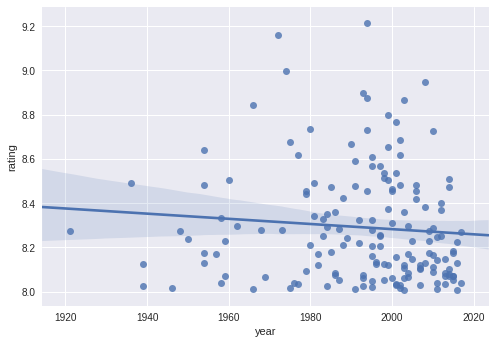

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.regplot(x="year", y="rating", data=tidy_df)
sns.plt.show()

The relative flatness of the best fit line and the relatively random scatter of points seem to indicate that there is indeed no notable relationship between a film's release year and its IMDb rating. The clustering of points near the bottom right is likely just a reflection of the tendency for more recent movies to exist in the websites database (IMDb was launched in 1990) and perhaps the proliferation of film industries around the world in more recent years.

Though, as a side note, the negative trend of the best fit line may say something about the degradation in quality of films with time.

### Ratings against budgets

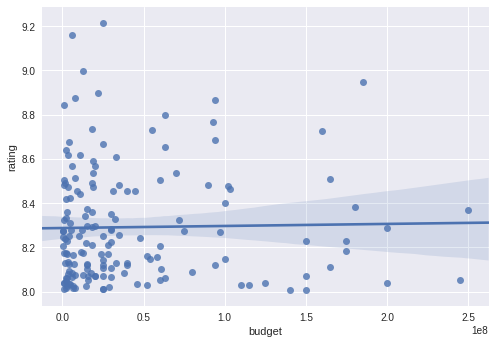

In [6]:
ax = sns.regplot(x="budget", y="rating", data=tidy_df)
sns.plt.show()

The flatness of this line indicates that there is no strong relationship between rating and budget.

### Ratings against gross revenues

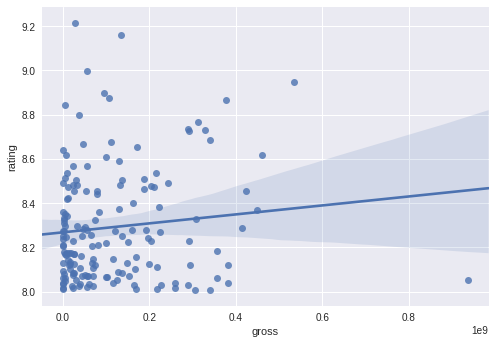

In [7]:
ax = sns.regplot(x="gross", y="rating", data=tidy_df)
sns.plt.show()

Though there is an upwards trend, ratings do not seem to be particularly strongly correlated with the gross revenue of a film. Like budget, gross is another dollar value and varies dramatically. A logarithmic scale on the gross axis might be of use here.

### Ratings against IMDb votes

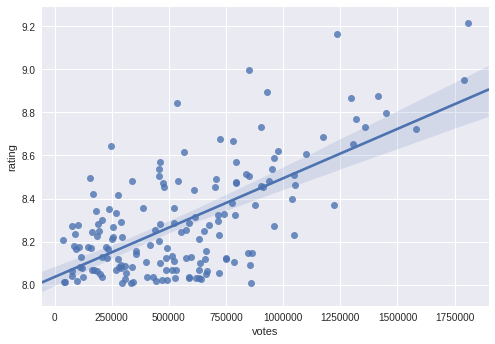

In [8]:
ax = sns.regplot(x="votes", y="rating", data=tidy_df)
sns.plt.show()

At a glance, this plot appears to have a much stronger correlation and with a tighter spread than the other plots. This probably means that people are more likely to rate the movie on a review site like IMDd if they internally rate the movie high, and less likely to rate if they internally rate the movie low. Or, perhaps more fundamentally, that people are more likely to go watch a film if they saw that it was rated highly on IMDb, and subsequently rate the film.

In any case, "votes" seems to be a promising variable for predicting ratings of film.

## Looking for possible interactions
Does rating or profit index vary significantly based on some category? Let's see how many unique directors, genres, countries, colors, and production companies there are to gauge a reasonable guess as to what category there may be interactions with.

In [9]:
def split_unique_values(values):
    items = []
    for entry in values:
        entry_items = entry.strip(', ').split(', ')
        for item in entry_items:
            if item not in items:
                items.append(item)
    return items

unique_directors = split_unique_values(tidy_df.director.unique())
unique_genres = split_unique_values(tidy_df.genres.unique())
unique_countries = split_unique_values(tidy_df.country.unique())
unique_colors = split_unique_values(tidy_df.color.unique())
unique_companies = split_unique_values(tidy_df.production_co.unique())

print('Unique directors: ' + str(len(unique_directors)))
print('Unique genres: ' + str(len(unique_genres)))
print('Unique countries: ' + str(len(unique_countries)))
print('Unique colors: ' + str(len(unique_colors)))
print('Unique production companies: ' + str(len(unique_companies)))

Unique directors: 104
Unique genres: 20
Unique countries: 29
Unique colors: 2
Unique production companies: 252


Just by the numbers, it seems genres, countries, or colors may have a potential impact on the average rating or financial success of a film. The other two categories have too many unique values to influence a data set of our size - they would average less than one data point per category.

### Ratings by film color

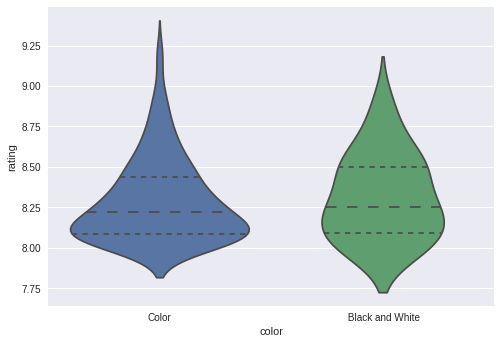

In [10]:
sns.violinplot(x='color', y='rating', data=tidy_df, inner='quart')
sns.plt.show()

No remarkable difference between ratings based on whether a film is in color.

### Ratings by genre
For this visualization, we have to work a bit on the data. Some films have multiple genres, and this is reflected in the genres column through comma-delimiting. If a film belongs to multiple genres, it should count once for each of them. We achieve this effect by splitting rows with multiple comma-delimited values in their genres column into multiple rows, each with one unique genre.

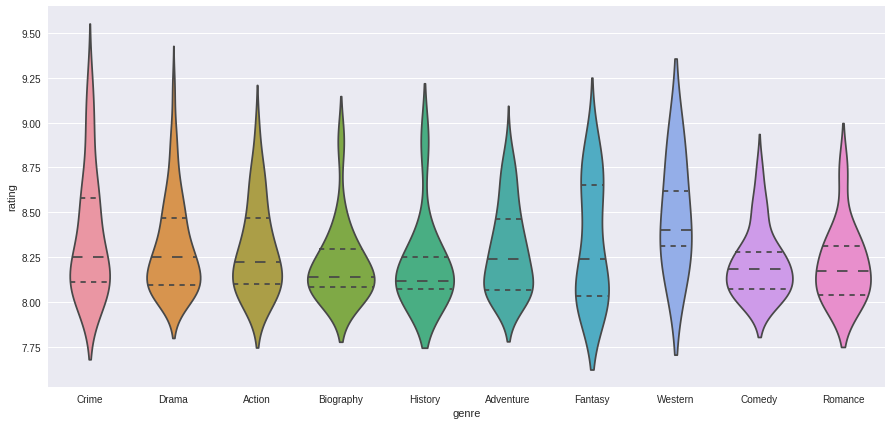

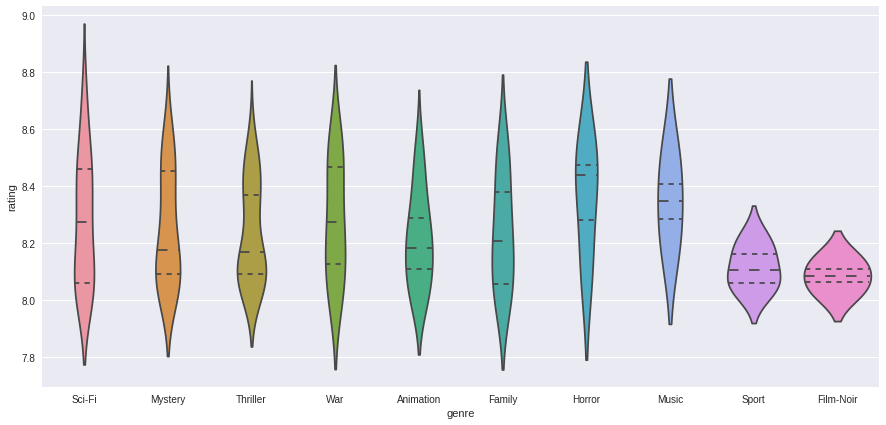

In [11]:
CHUNK_SIZE = 10

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

# Split multi-value genre rows into multiple rows, each with one genre
melted_genres = pd.concat([pd.Series(row['rating'], row['genres'].split(', '))
                         for _, row in tidy_df.iterrows()]).reset_index()
melted_genres.columns = ['genre', 'rating']

# Spread out the violins on separate plots so that there aren't too many on one plot
for genre_chunk in chunks(unique_genres, CHUNK_SIZE):
    chunk_df = melted_genres[melted_genres.genre.isin(genre_chunk)]
    f, ax = plt.subplots(figsize=(15, 7))
    sns.violinplot(x='genre', y='rating', data=chunk_df, inner='quart')

sns.plt.show()

### Ratings by country
Let's do the same for the countries category.

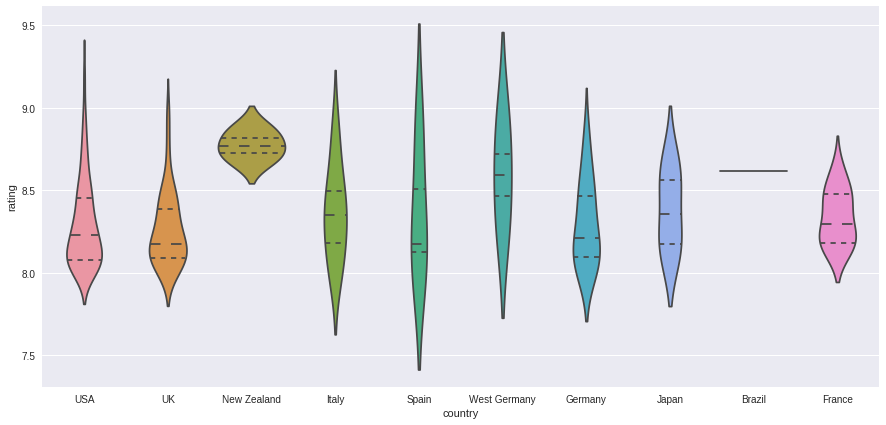

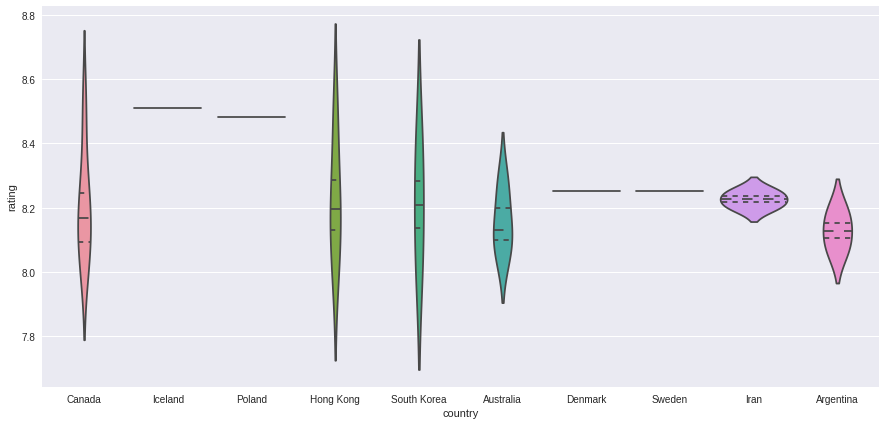

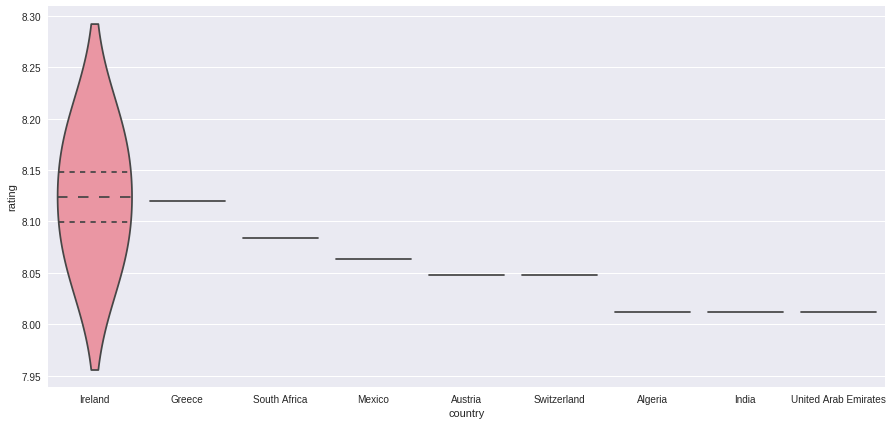

In [12]:
# Split multi-value genre rows into multiple rows, each with one genre
melted_countries = pd.concat([pd.Series(row['rating'], row['country'].split(', '))
                         for _, row in tidy_df.iterrows()]).reset_index()
melted_countries.columns = ['country', 'rating']

# Spread out the violins on separate plots so that there aren't too many on one plot
for country_chunk in chunks(unique_countries, CHUNK_SIZE):
    chunk_df = melted_countries[melted_countries.country.isin(country_chunk)]
    f, ax = plt.subplots(figsize=(15, 7))
    sns.violinplot(x='country', y='rating', data=chunk_df, inner='quart')

sns.plt.show()

Each of these categories are relatively even about a center line. It seems we are safe to proceed without incorporating interaction variables.

<a id="hypothesis-testing-and-machine-learning"></a>
# Hypothesis Testing and Machine Learning

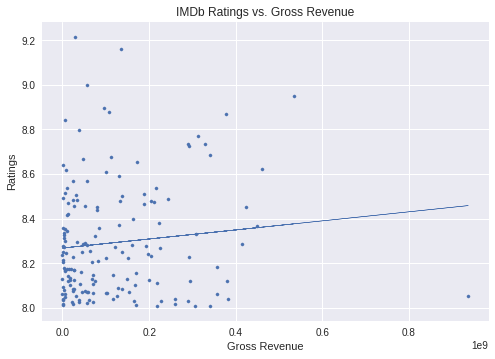

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.891
Date:                Thu, 18 May 2017   Prob (F-statistic):              0.171
Time:                        20:01:28   Log-Likelihood:                -7.4956
No. Observations:                 161   AIC:                             18.99
Df Residuals:                     159   BIC:                             25.15
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      8.2678      0.026    313.070      0.0

In [14]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import datasets, linear_model

length = len(tidy_df.index)
gross = tidy_df.gross.values.reshape(length, 1)
ratings = tidy_df.rating.values.reshape(length, 1)

regr = linear_model.LinearRegression()
regr.fit(gross, ratings)

# Plot ratings against gross revenue
plt.scatter(gross, ratings, s=10)
plt.plot(gross, regr.predict(gross), linewidth=0.5)
plt.title('IMDb Ratings vs. Gross Revenue')
plt.xlabel('Gross Revenue')
plt.ylabel('Ratings')
plt.show()

# Apply ordinary least-squares
est = smf.ols(formula='rating ~ gross', data=tidy_df).fit()
print(est.summary())

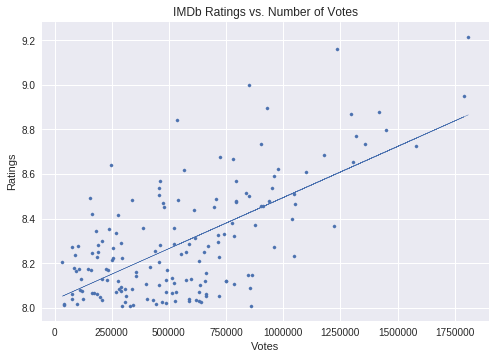

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     119.2
Date:                Thu, 18 May 2017   Prob (F-statistic):           4.60e-21
Time:                        20:32:04   Log-Likelihood:                 36.595
No. Observations:                 161   AIC:                            -69.19
Df Residuals:                     159   BIC:                            -63.03
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      8.0362      0.028    287.813      0.0

In [16]:
votes = tidy_df.votes.values.reshape(length, 1)
ratings = tidy_df.rating.values.reshape(length, 1)

regr.fit(votes, ratings)

# Plot ratings against gross revenue
plt.scatter(votes, ratings, s=10)
plt.plot(votes, regr.predict(votes), linewidth=0.5)
plt.title('IMDb Ratings vs. Number of Votes')
plt.xlabel('Votes')
plt.ylabel('Ratings')
plt.show()

# Apply ordinary least-squares
est = smf.ols(formula='rating ~ votes', data=tidy_df).fit()
print(est.summary())

# Summary and references
This tutorial highlighted some techniques for data analysis. Much more detail about the libraries and question on IMDB data come be find on the following links.

1. Pandas: http://pandas.pydata.org/pandas-docs/stable/
2. BeautifulSoup: https://www.crummy.com/software/BeautifulSoup/bs4/doc/
3. Numpy: http://www.numpy.org/
4. Seaborn: https://seaborn.pydata.org/
5. Matplotlib: https://matplotlib.org/
6. Statsmodels: http://www.statsmodels.org/stable/index.html
7. Sklearn: http://scikit-learn.org/stable/
8. SKLearn OLS Example: https://www.crummy.com/software/BeautifulSoup/bs4/doc/
9. IMDb Top 250 Movies: http://www.imdb.com/chart/top?ref_=nv_mv_250_6